## Imports

In [1]:
import numpy as np
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, HMC, Predictive
from numpyro.infer.initialization import init_to_value

import jax
from jax import random, vmap
import jax.numpy as jnp
from jax.nn import relu

from jax import config

config.update("jax_enable_x64", True)

display(jax.devices())

import pickle

import os
import sys

sys.path.append(os.path.abspath(os.path.join('..')))

from src.models.NumPyroModels import NumPyroModel
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.data_utils import *
from src.utils.numpyro_utils import *


%load_ext autoreload
%autoreload 2

%matplotlib inline

/home/codygrogan/PythonProjects/Uncertainty_Quantification/venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[cuda(id=0)]

## Creating Data Set

In [2]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    pass
    #plot_data_generation_diff(etas_train)

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


## Scaling Data and Converting

In [3]:
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_scaled_test = x_scaler.transform(etas_test)
y_scaled_test = y_scaler.transform(gs_test)

x_train = jnp.array(x_scaled_train, dtype=jnp.float64)
y_train = jnp.array(y_scaled_train, dtype=jnp.float64)

## Network and HMC parameters

In [8]:
hmc_checkpoints = "../Model_Checkpoints/HMC/"

#gold_step_size = 55e-5
#gold_trajectory_length = 1.6501

step_size = 5e-5
trajectory_length = 0.01
num_steps = int(np.ceil(trajectory_length // step_size))
print("Number of Steps: ", num_steps)

init_dict = pickle.load(open(hmc_checkpoints+"HMC_Initialize_large.pkl", "rb"))

for key, value in init_dict.items():
    print(key)
    init_dict[key] = jnp.array(value.astype(jnp.float64).T)
    print(init_dict[key].shape)

net_params = {
    "input_dim": 2,
    "output_dim": 3,
    "hidden_dim": 20,
    "num_layers": 4,
    "data_size": len(x_train),
    "layer_prior_scale": 5.0,
}

hmc_params = {
    "model": NumPyroModel(**net_params),
    "step_size": step_size,
    "trajectory_length": trajectory_length,
    "adapt_step_size": False,
    "dense_mass": True,
    "init_strategy": init_to_value(values=init_dict),
}

mcmc_params = {
    "num_warmup": 10,
    "num_samples": 10,
    "num_chains": 1
}



Number of Steps:  199
w1
(2, 20)
b1
(20,)
w2
(20, 20)
b2
(20,)
w3
(20, 20)
b3
(20,)
w4
(20, 3)
b4
(3,)


## Run Training

In [9]:
print(hmc_params["model"])

kernel = HMC(**hmc_params)

mcmc = MCMC(kernel, **mcmc_params)

rng_key = random.PRNGKey(0)

mcmc.run(rng_key, x_train, y_train)

Layer 1: 2 -> 20
Layer 2: 20 -> 20
Layer 3: 20 -> 20
Layer 4: 20 -> 3



sample: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it, 200 steps of size 5.00e-05. acc. prob=1.00]


## Saving MCMC Run

In [10]:
save_prefix = f"HMC_{mcmc_params['num_warmup']}_{mcmc_params['num_samples']}_{num_steps}"

save_numpyro_mcmc(mcmc, hmc_checkpoints, save_prefix)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]     -0.24      0.01     -0.25     -0.26     -0.22      4.93      1.04
     b1[1]     -0.07      0.00     -0.07     -0.08     -0.07      3.95      1.51
     b1[2]      0.67      0.01      0.67      0.65      0.69      5.93      1.04
     b1[3]      0.09      0.01      0.09      0.07      0.10      4.45      1.19
     b1[4]      0.36      0.01      0.36      0.34      0.38      2.82      1.84
     b1[5]     -0.46      0.02     -0.45     -0.48     -0.43      3.71      1.70
     b1[6]      0.02      0.01      0.02      0.01      0.04      6.41      0.91
     b1[7]     -0.31      0.02     -0.30     -0.33     -0.29      4.34      0.97
     b1[8]      0.16      0.01      0.16      0.16      0.18     18.66      0.90
     b1[9]     -0.53      0.01     -0.53     -0.55     -0.51      3.57      1.85
    b1[10]      0.09      0.01      0.09      0.08      0.10     45.45      0.96
    b1[11]      0.74      0

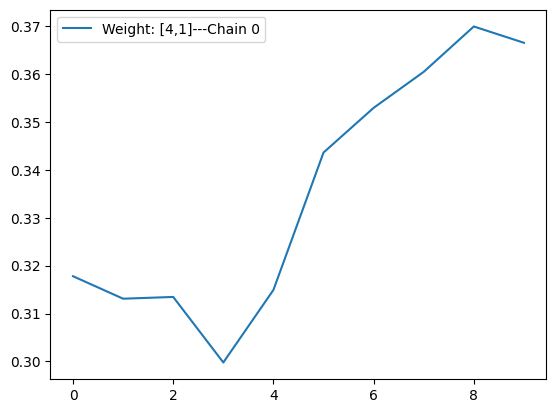

In [12]:
saves = "../Model_Checkpoints/HMC/HMC_10_10_199"
num_samples = 2
samples = []

samples_dict = pickle.load(open(saves+'_samples.pkl', 'rb'))
last_state = pickle.load(open(saves+'_last_state.pkl', 'rb'))


for k, v in samples_dict.items():
    samples_dict[k] = jnp.expand_dims(v, 0)

kernel = HMC(**hmc_params)

mcmc = MCMC(kernel, **mcmc_params)

mcmc._states = {'z': samples_dict}
mcmc._last_state = last_state

print(mcmc.print_summary())


for key, value in samples_dict.items():
    print(key, value.shape)

import matplotlib.pyplot as plt
plt.rcParams['text.usetex']= False

params = samples_dict['w1']

ind1 = 4
ind2 = 1
for i in range(1):
    plt.plot(params[0, :, ind1, ind2], label=f"Weight: [{ind1},{ind2}]---Chain {i}")

plt.legend()
plt.show()

## Predictions

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


0.010831882806851515


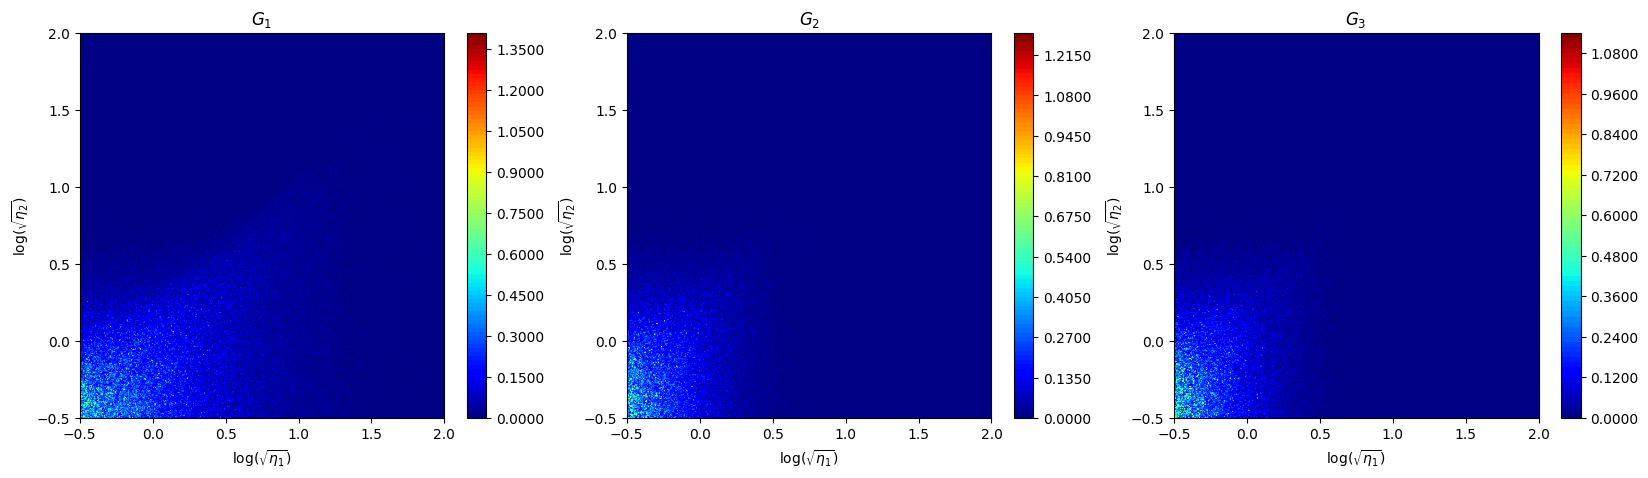

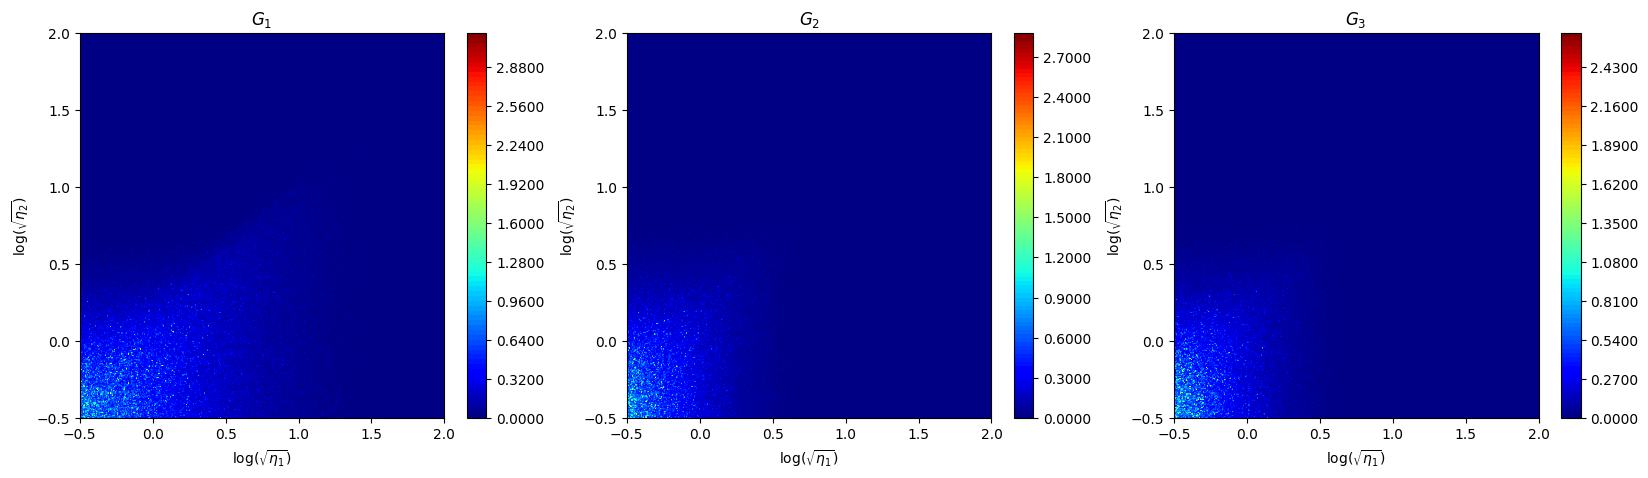

In [22]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG")
etas, G_s = gen(eta1, eta2)

etas = jnp.array(etas)
target = jnp.array(G_s)

model_test = NumPyroModel(**net_params)
model_test.data_size = etas.shape[0]

etas = x_scaler.transform(etas)

predictive = Predictive(model_test, posterior_samples=mcmc.get_samples(), num_samples=10)

pred = np.array(predictive(random.PRNGKey(0), etas)['Y'])

for i in range(pred.shape[0]):
    pred[i] = y_scaler.inverse_transform(pred[i])

pred_mean = jnp.mean(pred, axis=0)
pred_std = jnp.std(pred, axis=0)

del pred
del predictive

print(jnp.mean(jnp.abs(target - pred_mean)))

target = target.T.reshape(3, dim, dim)
pred_mean = pred_mean.T.reshape(3, dim, dim)
pred_std = pred_std.T.reshape(3, dim, dim)

plot_heat_map_3D(x_grid, y_grid, np.abs(pred_mean - target))

plot_heat_map_3D(x_grid, y_grid, pred_std)